# Riemann Problem

In [663]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os

from kuibit.simdir import SimDir
from kuibit.grid_data import UniformGrid

In [664]:
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.grid'] = True
mpl.rcParams['font.size'] = 12

In [665]:
# Global variables
L = 1.0 # Domain

# Wether to save images or not
save = False

# DPI of the saved images
dpi = 500

# Varibales to store the figures
figures = []
figure_names = []

## Exact Solution

In [666]:
# Initial data from the Exact Riemann solver of https://www.brunogiacomazzo.org/?page_id=395
exact = np.loadtxt("Sod_exact.dat")

In [667]:
x_exact = exact[:, 0]
rho_exact = exact[:, 1]
press_exact = exact[:, 2] # Note: this is P_gas + P_mag
vx_exact = exact[:, 3]
vy_exact = exact[:, 4]
vz_exact = exact[:, 5]
By_exact = exact[:, 6]
Bz_exact = exact[:, 7]

# Save the desired quantities
qty_exact = [rho_exact, press_exact, vx_exact]
qty_labels = [r'$\rho$', r'$P$', r'$v_x$']
qty_initial = [(1, 0.125), (1, 0.1), (0, 0)]

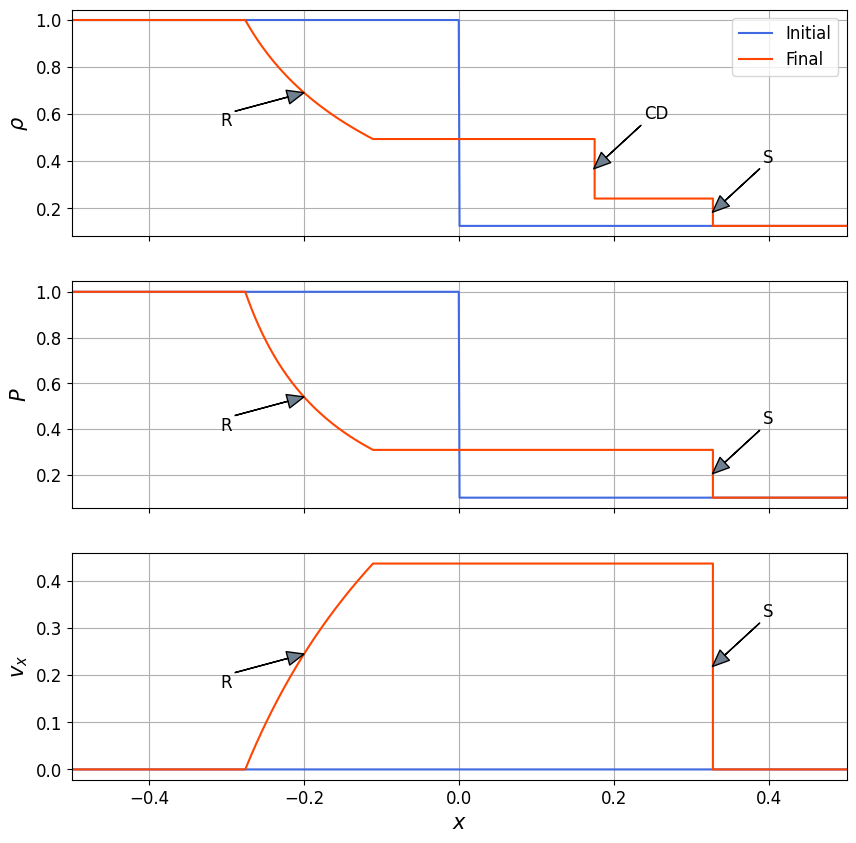

In [668]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True, dpi=100)

# Plot the exact solutions and the initial conditions
for i, ax in zip(range(len(qty_exact)), axes.flat):
    ax.set_ylabel(qty_labels[i])

    # Initial conditions
    ax.plot(x_exact, np.where(x_exact < 0, *qty_initial[i]), color='royalblue', label='Initial')

    # Final conditions
    ax.plot(x_exact, qty_exact[i], color='orangered', label='Final')

    # Limit the axes
    ax.set_xlim(x_exact.min(), x_exact.max())

    # Plot the legend on the first plot
    if i == 0:
        ax.legend()

# Shut down other plots
for i in range(len(qty_exact), len(axes.flat), 1):
    axes.flat[i].set_visible(False)

arrowprops = dict(width=0.1, headwidth=10, facecolor='slategray')
# Annotations
for i, ax in zip(range(len(qty_exact)), axes.flat):
    index = np.where(x_exact <= -0.2)[0][-1]
    ax.annotate('R',
                xy=(x_exact[index], qty_exact[i][index]),
                xytext=(-5, -2), textcoords='offset fontsize',
                arrowprops=arrowprops)
    
    index = np.where(x_exact <= 0.327)[0][-1]
    ax.annotate('S',
                xy=(x_exact[index], (qty_exact[i][index]+qty_exact[i][index+5])/2),
                xytext=(3, 3), textcoords='offset fontsize',
                arrowprops=arrowprops)
    
    if i == 0:
        index = np.where(x_exact <= 0.174)[0][-1]
        ax.annotate('CD',
                    xy=(x_exact[index], (qty_exact[i][index]+qty_exact[i][index+5])/2),
                    xytext=(3, 3), textcoords='offset fontsize',
                    arrowprops=arrowprops)
    if i == 2:
        ax.set_xlabel(r'$x$')

figures.append(fig)
figure_names.append('all_exact_if')

plt.show()

## Numerical Results

In [669]:
gf = SimDir("Sod_1d_1600").gf
print(gf)


Available grid data of dimension 1D (x): 
['tau', 'dens', 'press', 'vel[1]', 'rho', 'vel[0]', 'vel[2]', 'eps', 'w_lorentz', 'scon[1]', 'scon[0]', 'scon[2]']


Available grid data of dimension 1D (y): 
['rho', 'vel[1]', 'tau', 'dens', 'press', 'eps', 'vel[2]', 'vel[0]', 'scon[1]', 'w_lorentz', 'scon[2]', 'scon[0]']


Available grid data of dimension 1D (z): 
['scon[2]', 'scon[0]', 'w_lorentz', 'scon[1]', 'vel[2]', 'vel[0]', 'eps', 'vel[1]', 'tau', 'press', 'dens', 'rho']


Available grid data of dimension 2D (xy): 
[]


Available grid data of dimension 2D (xz): 
[]


Available grid data of dimension 2D (yz): 
[]


Available grid data of dimension 3D (xyz): 
[]



In [670]:
vars1d = gf.x
print(vars1d)


Available grid data of dimension 1D (x): 
['tau', 'dens', 'press', 'vel[1]', 'rho', 'vel[0]', 'vel[2]', 'eps', 'w_lorentz', 'scon[1]', 'scon[0]', 'scon[2]']



In [671]:
# Support variables
qty_keys = ['rho', 'press', 'vel[0]']
qty_keys_indexes_dict = dict(zip(qty_keys, range(len(qty_keys))))

# Print the number of iterations available for each quantity
print([len(vars1d[key].iterations) for key in qty_keys])

# Print the number of iterations
print(vars1d[qty_keys[0]].iterations)

[81, 81, 81]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800]


In [672]:
# Make a uniform grid. Must be smaller than the full domain [-0.5, 0.5]
small_grid = UniformGrid([101], x0=[-0.45], x1=[0.45])

# Make a function to plot the desired quantity at the specified iterations
#
# qty: OneGridFunctionH5 (from SimDir.gf.x[qty_key])
# qty_label: The label of the quantity to be plotted
# iterations: list of iterations to be plotted
# ax: the Axes object on which the data are plotted on
#
# Returns the list of plotted lines for each iteration (its a list of lists, but the inner list
# in this case is one-sized. See matplotlib documentation)
def plot_qty_iterations(qty, qty_label, iterations, ax,
                        set_xlabel=True, set_ylabel=True, set_xlim=True):
    # Get the required iterations
    qty_iters = [qty.read_on_grid(it, small_grid) for it in iterations]

    lines = []

    # Plot the iterations
    for i in range(len(iterations)):
        if set_xlabel:
            ax.set_xlabel(r'$x$')
        if set_ylabel:
            ax.set_ylabel(qty_label)
        
        lines.append(ax.plot(*qty_iters[i].coordinates_meshgrid(), qty_iters[i].data_xyz))
        if set_xlim:
            ax.set_xlim(np.min(*qty_iters[i].coordinates_meshgrid()), np.max(*qty_iters[i].coordinates_meshgrid()))
    
    # Return the lines artists
    return lines

### Final condition

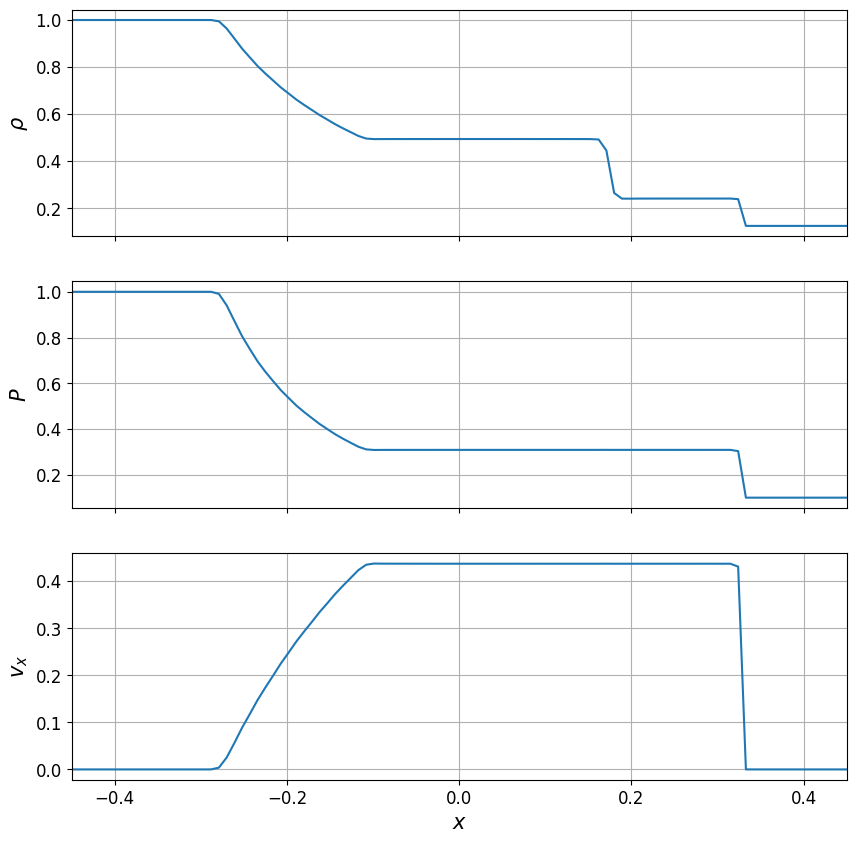

In [673]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True, dpi=100)

for key, i, ax in zip(qty_keys, range(len(qty_keys)), axes.flat):
    if i == len(qty_keys) - 1:
        print_x_label = True
    else:
        print_x_label = False
        
    plot_qty_iterations(vars1d[key], qty_labels[qty_keys_indexes_dict[key]], [vars1d[key].iterations[-1]], ax, set_xlabel=print_x_label)

plt.show()

### Snapshots

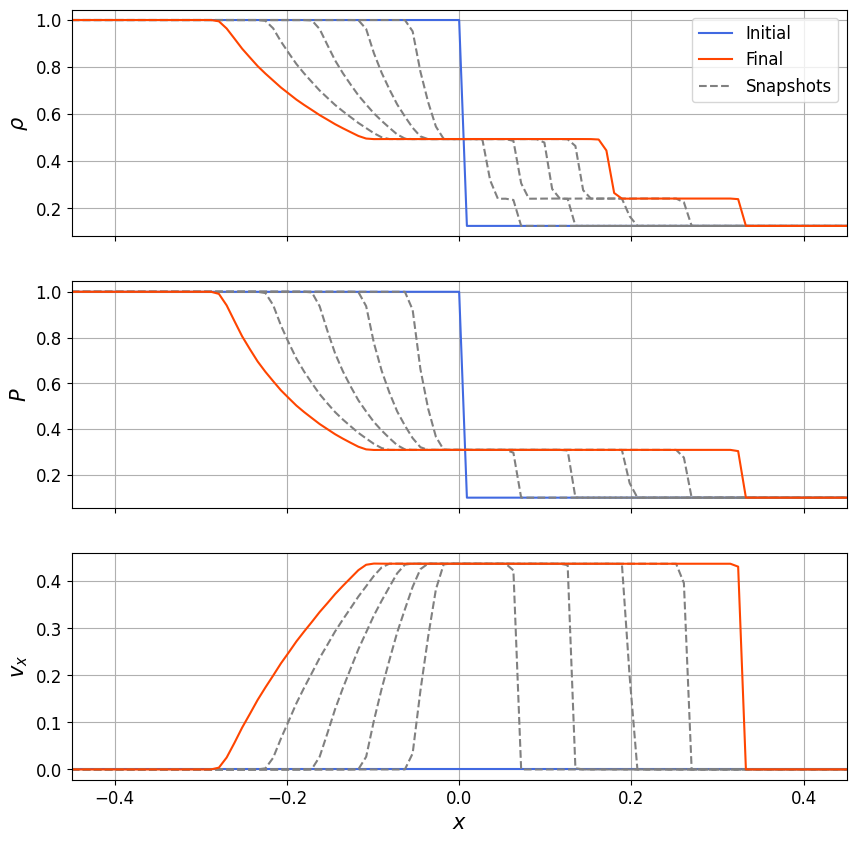

In [674]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True, dpi=100)

for key, i, ax in zip(qty_keys, range(len(qty_keys)), axes.flat):
    # Interval from iterations to print
    iteration_interval = len(vars1d[key].iterations) // 5

    if i == len(qty_keys) - 1:
        print_x_label = True
    else:
        print_x_label = False

    # Plot iterations at the given interval, but be sure to include the final one
    lines = plot_qty_iterations(vars1d[key], qty_labels[qty_keys_indexes_dict[key]],
                                [it for i, it in enumerate(vars1d[key].iterations)
                                 if i % iteration_interval == 0 or it == vars1d[key].iterations[-1]],
                                ax, set_xlabel=print_x_label)
    for j, l in enumerate(lines):
        # Just one artist per plot -> Subscript l: l[0] (ax.plot() returns a list (of lines))
        if j != 0 and j != len(lines) - 1:
            l[0].set(color='gray', linestyle='--', label='Snapshots')
        elif j == 0:
            l[0].set(color='royalblue', label='Initial')
        elif j == len(lines) - 1:
            l[0].set(color='orangered', label='Final')

    # For some reason you have to pass the legend_artists explicitely to the 'handles' parameter
    # even though it seems to be the firts positional argument from the documentation
    # However a deeper look into the documentation suggests that it is supposed to work like that
    if i == 0:
        ax.legend(handles=[lines[0][0], lines[len(lines) - 1][0], lines[1][0]])

figures.append(fig)
figure_names.append('all_1600_snapshots')

plt.show()

### Comparison of interpolated initial data and raw initial data

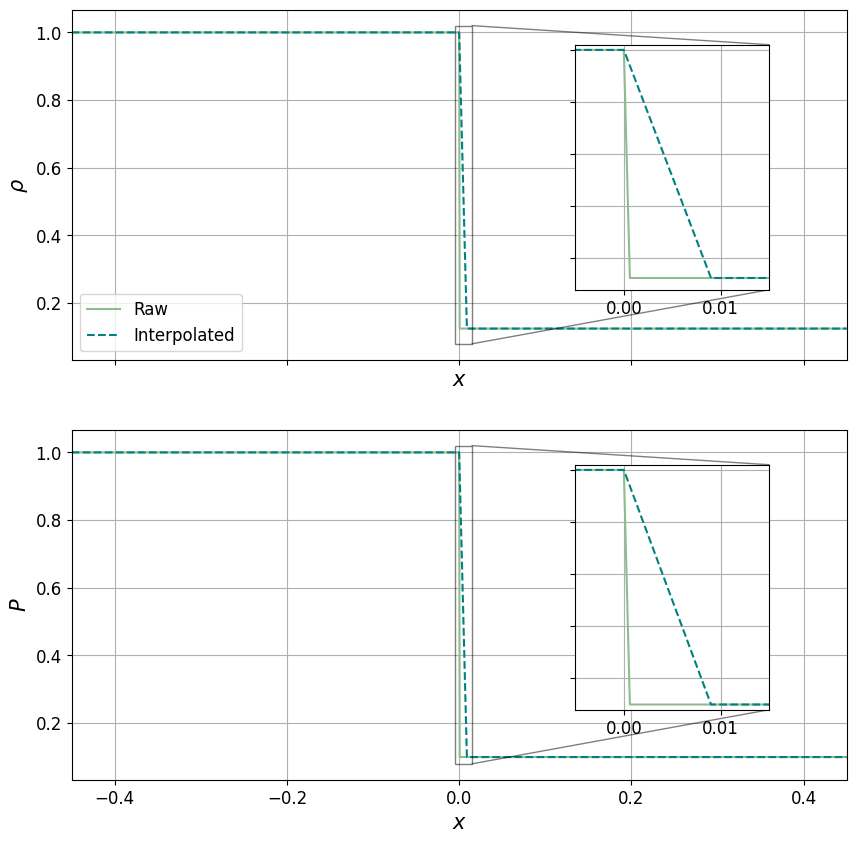

In [675]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, dpi=100)

for key, i, ax in zip([key for key in qty_keys if key != 'vel[0]'], range(len(qty_keys)), axes.flat):
    axins = ax.inset_axes([0.65, 0.2, 0.25, 0.7],
                          xlim=(-0.005, 0.015), ylim=(0.08, 1.02),
                          yticklabels=[])
    
    ax.indicate_inset_zoom(axins, edgecolor='black')

    axins_list = [axins]

    for ax_ in [ax] + axins_list:
        if ax_ in axins_list:
            set_xlim = False
            print_x_label = False
            print_y_label = False
        else:
            set_xlim = True
            print_y_label = True
            if i == len(qty_keys) - 1 - 1:
                print_x_label = True

        # Plot the initial raw data
        ax_.plot(vars1d[key][vars1d[key].iterations[0]][0][0].coordinates()[0].data,
                vars1d[key][vars1d[key].iterations[0]][0][0].data,
                color='darkseagreen', label='Raw')
        
        # Plot the intial iteration (initial interpolated data)
        lines = plot_qty_iterations(vars1d[key], qty_labels[qty_keys_indexes_dict[key]],
                                    [vars1d[key].iterations[0]],
                                    ax_, set_xlabel=print_x_label, set_ylabel=print_y_label, set_xlim=set_xlim)
        
        for l in lines:
            l[0].set(color='teal', linestyle='--', label='Interpolated')
    
    if i == 0:
        ax.legend()

figures.append(fig)
figure_names.append('all_1600_initial_compare')

plt.show()

### Comparison of different resolutions

In [676]:
# Get the folders of the solutions
sol_folders = [path for path in os.listdir()
               if os.path.isdir(path) and path.split('_')[0] == 'Sod']

# Save the resolutions
resolutions = [L / int(folder_name.split('_')[2]) for folder_name in sol_folders]

# Read the solutions
vars1d_list = [SimDir(folder_name).gf.x for folder_name in sol_folders]

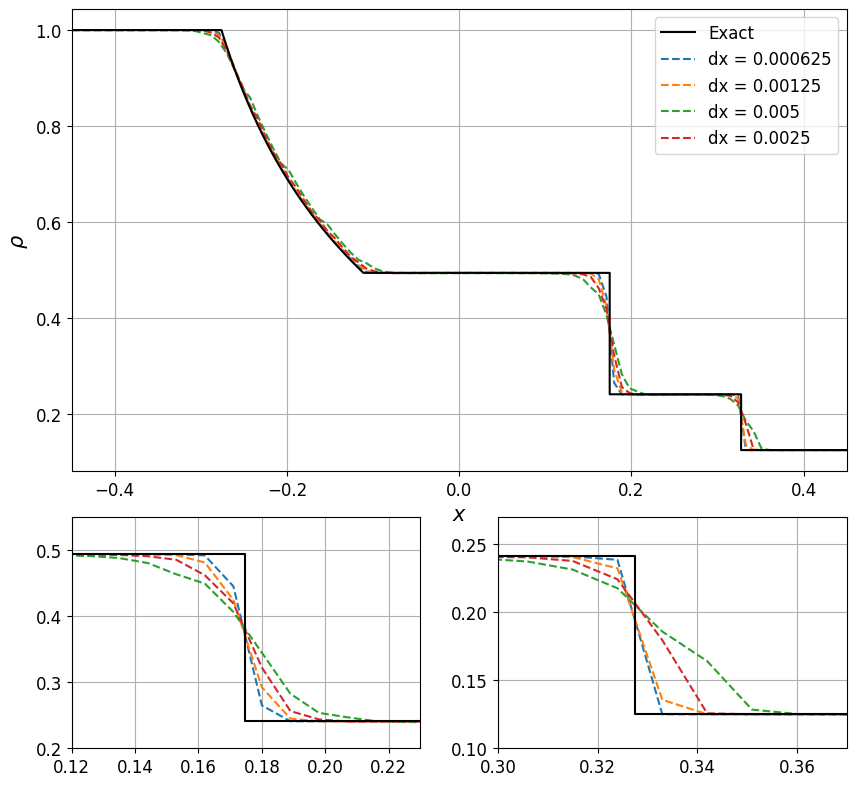

In [677]:
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=100)

axins2 = ax1.inset_axes([0, 1 * -0.6, 0.45, 0.5],
                        xlim=(0.12, 0.23), ylim=(0.2, 0.55))
axins3 = ax1.inset_axes([0.55, 1 * -0.6, 0.45, 0.5],
                        xlim=(0.3, 0.37), ylim=(0.1, 0.27))

inset_axes = [axins2, axins3]
axes = [ax1] + inset_axes

var_key = 'rho'

for ax in axes:
# Plot the exact solution
    ax.plot(x_exact, qty_exact[qty_keys_indexes_dict[var_key]],
            label='Exact', color='black', zorder=len(resolutions))

    # Plot the computed solutions
    for vars, res in zip(vars1d_list, resolutions):
        lines = plot_qty_iterations(vars[var_key], qty_labels[qty_keys_indexes_dict[var_key]],
                                    [vars[var_key].iterations[-1]], ax,
                                    set_xlabel=(ax not in inset_axes), set_ylabel=(ax not in inset_axes),
                                    set_xlim=(ax not in inset_axes))

        for l in lines:
            l[0].set(linestyle='--', label='dx = {0}'.format(res))

ax1.legend()

plt.show()

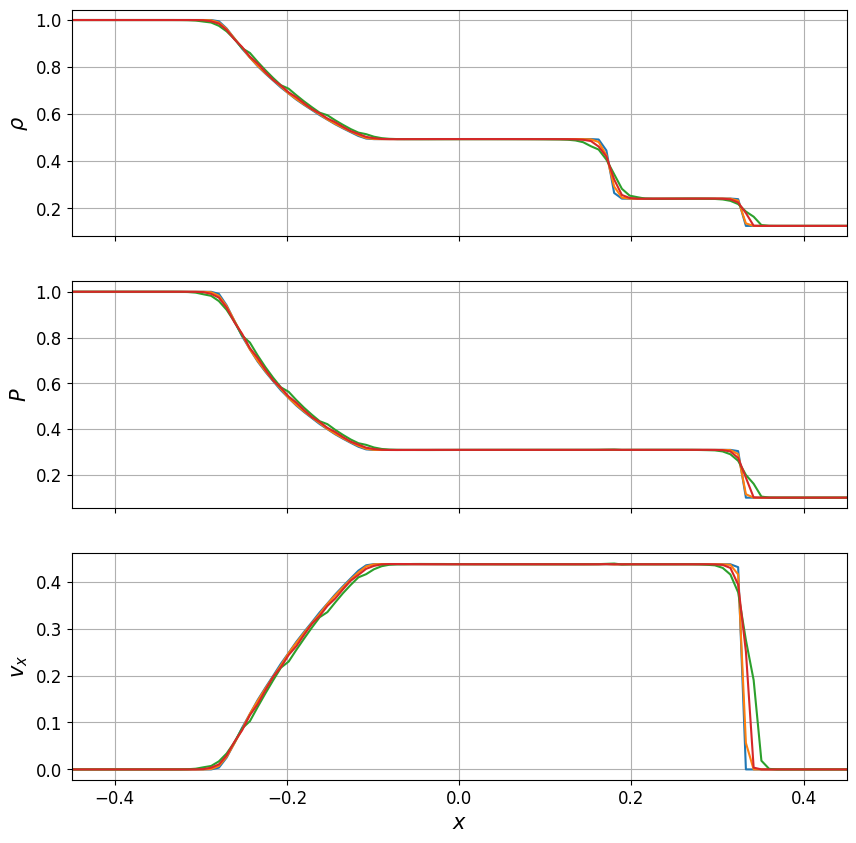

In [678]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True, dpi=100)

for key, i, ax in zip(qty_keys, range(len(qty_keys)), axes.flat):

    if i == len(qty_keys) - 1:
        print_x_label = True
    else:
        print_x_label = False

    for vars in vars1d_list:
        plot_qty_iterations(vars[key], qty_labels[qty_keys_indexes_dict[key]],
                            [vars[key].iterations[-1]], ax, set_xlabel=print_x_label)
        
plt.show()

## Save results

In [679]:
if save:
    os.makedirs('images', exist_ok=True)
    for figure, fig_name in zip(figures, figure_names):
        figure.savefig(os.path.join('images', fig_name), dpi=dpi)

## Kuibit Standard Methods for Plots

We create a uniform grid and plot the data on it. Kuibit indeed assumes that data were produced on a grid with several meshes (AMR). In our case the grid was already uniform, so later we will see an alternative way to plot the data without interpolating them on a new grid.

In [680]:
rho = vars1d.fields.rho

In [681]:
small_grid = UniformGrid([101], x0=[-0.45], x1=[0.45])

In [682]:
rho_final = rho.read_on_grid(rho.iterations[-1], small_grid)

In [683]:
print(*rho_final.coordinates_meshgrid())

[-4.50000000e-01 -4.41000000e-01 -4.32000000e-01 -4.23000000e-01
 -4.14000000e-01 -4.05000000e-01 -3.96000000e-01 -3.87000000e-01
 -3.78000000e-01 -3.69000000e-01 -3.60000000e-01 -3.51000000e-01
 -3.42000000e-01 -3.33000000e-01 -3.24000000e-01 -3.15000000e-01
 -3.06000000e-01 -2.97000000e-01 -2.88000000e-01 -2.79000000e-01
 -2.70000000e-01 -2.61000000e-01 -2.52000000e-01 -2.43000000e-01
 -2.34000000e-01 -2.25000000e-01 -2.16000000e-01 -2.07000000e-01
 -1.98000000e-01 -1.89000000e-01 -1.80000000e-01 -1.71000000e-01
 -1.62000000e-01 -1.53000000e-01 -1.44000000e-01 -1.35000000e-01
 -1.26000000e-01 -1.17000000e-01 -1.08000000e-01 -9.90000000e-02
 -9.00000000e-02 -8.10000000e-02 -7.20000000e-02 -6.30000000e-02
 -5.40000000e-02 -4.50000000e-02 -3.60000000e-02 -2.70000000e-02
 -1.80000000e-02 -9.00000000e-03  5.55111512e-17  9.00000000e-03
  1.80000000e-02  2.70000000e-02  3.60000000e-02  4.50000000e-02
  5.40000000e-02  6.30000000e-02  7.20000000e-02  8.10000000e-02
  9.00000000e-02  9.90000

In [684]:
print(rho_final.data_xyz)

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.99999973
 0.99991824 0.99450132 0.96396458 0.92132116 0.8780547  0.84085507
 0.80409277 0.77235688 0.74281332 0.71331626 0.68758711 0.66172923
 0.63903318 0.61758515 0.59586305 0.57666131 0.55713922 0.53984344
 0.52345147 0.50724057 0.49621629 0.4938507  0.49401614 0.49408523
 0.49411878 0.49409823 0.49412957 0.49414843 0.49414514 0.49416878
 0.49417645 0.49417817 0.49416255 0.4941845  0.49418516 0.49417115
 0.49417898 0.49418521 0.49418124 0.49416123 0.4941804  0.494176
 0.49414857 0.49416479 0.49415715 0.49413217 0.49412006 0.4940966
 0.49404249 0.4938766  0.49217608 0.44544408 0.26492308 0.24090887
 0.24077166 0.24104495 0.24113131 0.24117928 0.24119749 0.24120763
 0.24120546 0.24122211 0.24122319 0.24121889 0.24121906 0.24122869
 0.24123163 0.24121412 0.23869069 0.12501301 0.125      0.125
 0.125      0.125  

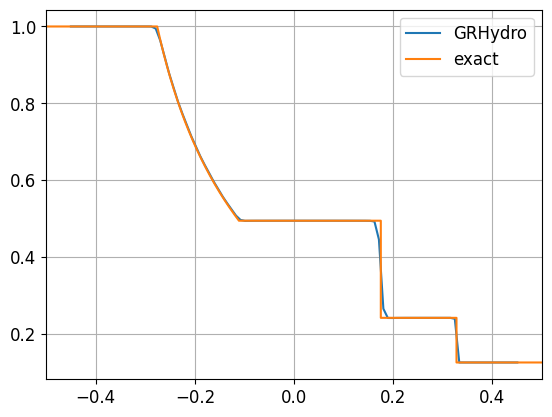

In [685]:
plt.plot(*rho_final.coordinates_meshgrid(), rho_final.data_xyz, label="GRHydro")
plt.plot(x_exact, rho_exact, label="exact")
plt.xlim(-0.5, 0.5)
plt.legend()
plt.show()

## Alternative Method
This method can only be used with simulations that used only one refinement level (i.e., a uniform grid) and using only 1 MPI process.

In [686]:
#[iterazione][refinement level][component number]
rho[0][0][0].data

array([1.   , 1.   , 1.   , ..., 0.125, 0.125, 0.125])

In [687]:
rho[0][0][0].coordinates()[0].data

array([-0.499375, -0.49875 , -0.498125, ...,  0.498125,  0.49875 ,
        0.499375])

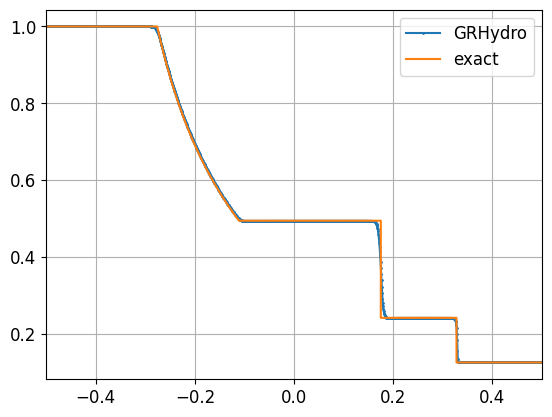

In [688]:
plt.plot(rho[rho.iterations[-1]][0][0].coordinates()[0].data, rho[rho.iterations[-1]][0][0].data,
         label="GRHydro", marker='o', markersize=1)
plt.plot(x_exact, rho_exact, label="exact")
plt.xlim(-0.5, 0.5)
plt.legend()
plt.show()